# Execute all versions of lid driven cavity problem

In [36]:
from pathlib import Path
from xml.etree import ElementTree
path = "bin"
programs = {
    "Lid driven cavity": "lidDriven",
    "Lid driven cavity GPU": "lidDrivenGPU",
    # "Lid driven cavity iterative GPU" : "lidDrivenIterativeGPU" # useless...
    "Lid driven cavity GPU with DSS" : "lidDrivenDSSGPU"
}
hs = [h/1000.0 for h in range(20, 6, -2)]

Create parameter files

In [37]:
def get_output_path(program, h):
    return Path("benchmark", f"{program}_{int(h*1000):0>2}_result.h5")
def get_param_path(program, h):
    return Path("..", "params", "benchmark", f"chanelFlow_{program}_{int(h*1000):0>2}.xml")

In [38]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlow.xml"
for name, program in programs.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(program, h)))
        param_output_path = get_param_path(program, h)
        params_tree.write(param_output_path)

Run program for every parameter file

In [39]:
for name, program in programs.items():
    for h in hs:
        param_path = get_param_path(program, h)
        program_path = Path("..", "bin", program)
        output_path = Path('..') / get_output_path(program, h)
        if Path.exists(output_path):
            continue
        print("Executing", name, "for h =", h)
        !../bin/{program} {param_path} 


Executing Lid driven cavity GPU with DSS for h = 0.02
h:0.02, N: 2277, dt:0.1
Problem size: 2278 2278, nonzeros: 31878
10 - t:1 max u_y:0.0234295 @ x:0.0908523  (max div:6.06618)
20 - t:2 max u_y:0.0252587 @ x:0.128638  (max div:3.6495)
30 - t:3 max u_y:0.0311025 @ x:0.204768  (max div:1.77669)
40 - t:4 max u_y:0.0379845 @ x:0.204768  (max div:0.885512)
50 - t:5 max u_y:0.0461333 @ x:0.377819  (max div:0.672332)
60 - t:6 max u_y:0.0723569 @ x:0.53903  (max div:0.41808)
70 - t:7 max u_y:0.12304 @ x:0.53903  (max div:0.322734)
80 - t:8 max u_y:0.154041 @ x:0.479766  (max div:0.305433)
90 - t:9 max u_y:0.183781 @ x:0.455599  (max div:0.241322)
100 - t:10 max u_y:0.196802 @ x:0.455599  (max div:0.201558)
110 - t:11 max u_y:0.210226 @ x:0.377819  (max div:0.163063)
120 - t:12 max u_y:0.227005 @ x:0.377819  (max div:0.121454)
130 - t:13 max u_y:0.233739 @ x:0.377819  (max div:0.0984679)
140 - t:14 max u_y:0.240554 @ x:0.341837  (max div:0.0999758)
150 - t:15 max u_y:0.247877 @ x:0.321885  (m

Display benchmarking results

In [40]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

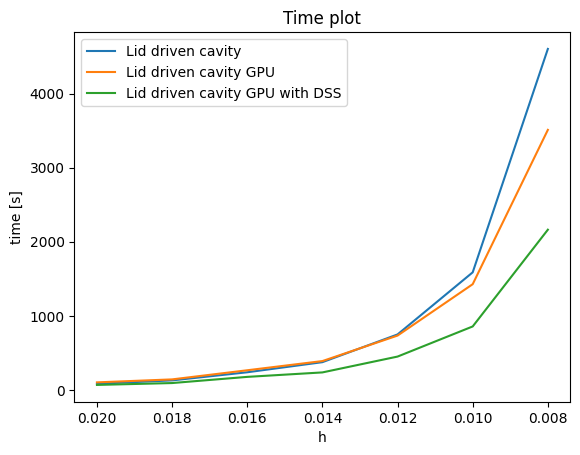

In [44]:
fig, ax = plt.subplots()
for name, program in programs.items():
    ts = []
    for h in hs:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            time = f.attrs["time"]
            ts.append(time)
    ax.plot(hs, ts, label=name)
plt.gca().invert_xaxis()
ax.set_xlabel('h')
ax.set_ylabel('time [s]')
ax.set_title("Time plot")
ax.legend()

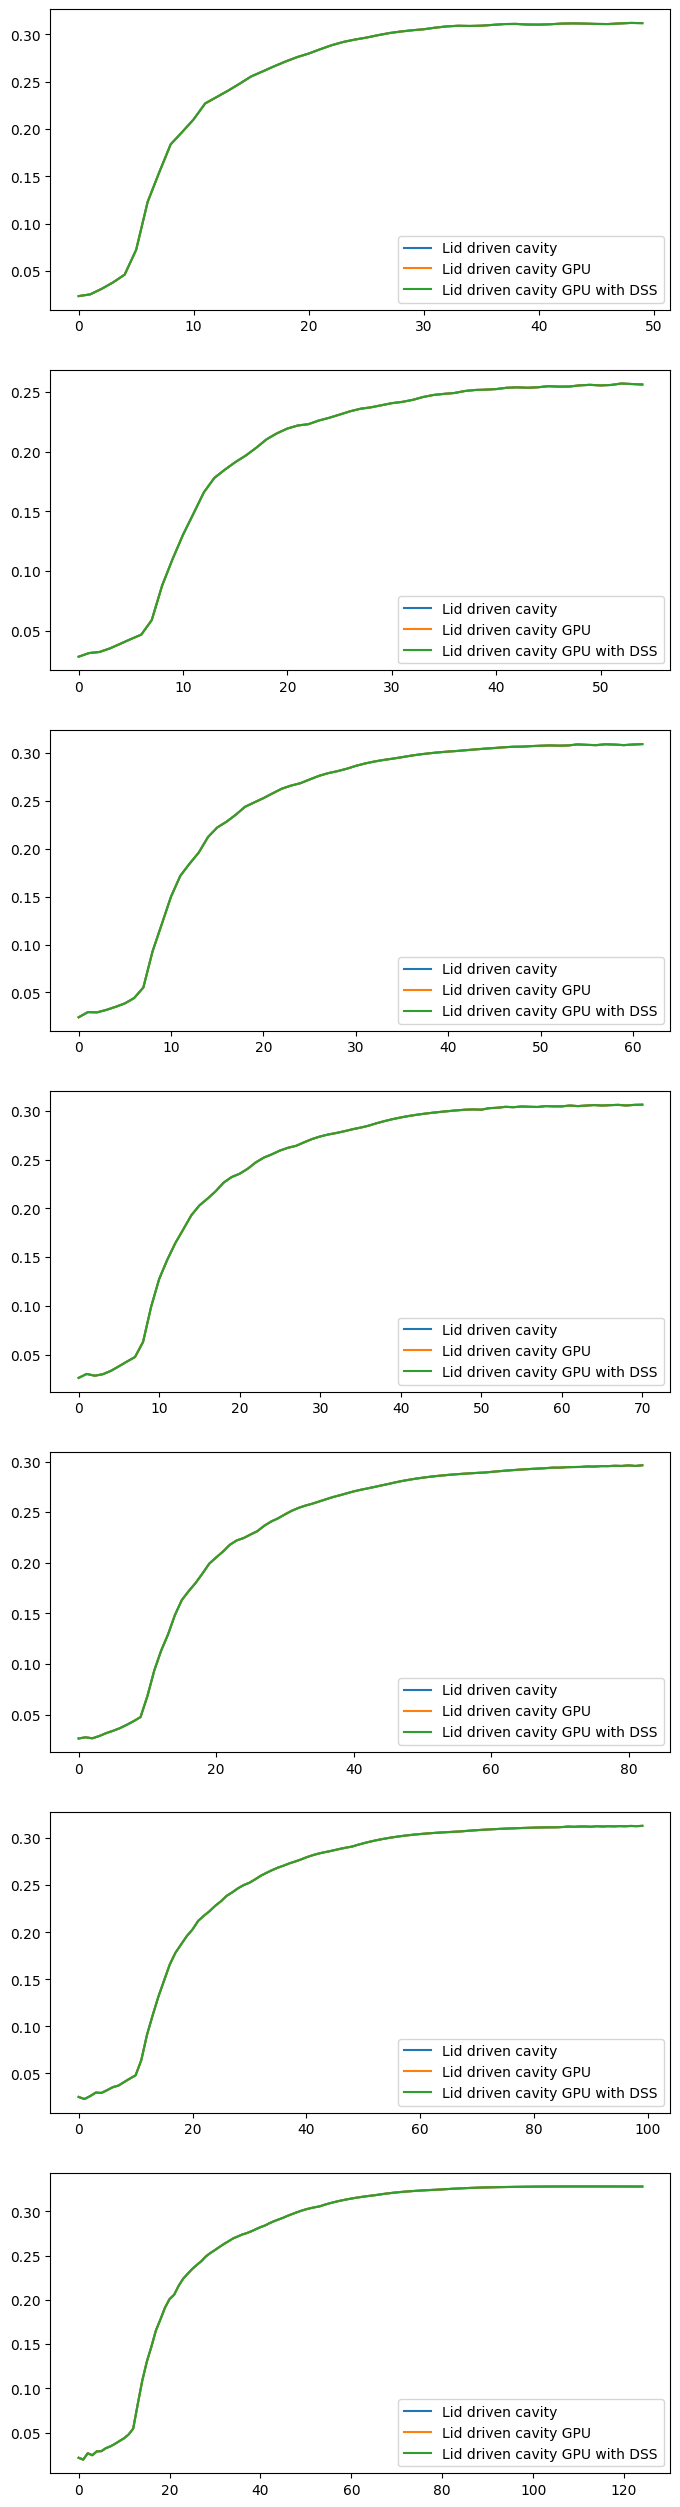

In [42]:
fig, axs = plt.subplots(len(hs), figsize=(8,32))
for i, h in enumerate(hs):
    for name, program in programs.items():
        result_file = Path('..') / get_output_path(program, h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            xs = list(range(len(velocity[0])))
            axs[i].plot(xs, velocity[0], label=name)
            axs[i].legend()

Norm of difference between matrices that represent final velocity fields

In [45]:
cpu_program = 'Lid driven cavity'
gpu_program = "Lid driven cavity GPU with DSS"
for i, h in enumerate(hs):
    cpu_result_file = Path('..') / get_output_path(programs[cpu_program], h)
    with h5py.File(cpu_result_file) as f:
        velocity_cpu = np.array(f['velocity'], dtype=np.float64)
    gpu_result_file = Path('..') / get_output_path(programs[gpu_program], h)
    with h5py.File(gpu_result_file) as f:
        velocity_gpu = np.array(f['velocity'], dtype=np.float64)
    print(f"h = {h}:", np.linalg.norm(velocity_cpu - velocity_gpu))

h = 0.02: 5.6932346799006306e-12
h = 0.018: 9.041355950757305e-09
h = 0.016: 7.080589543565959e-12
h = 0.014: 1.2814316201047207e-11
h = 0.012: 8.633796528192277e-13
h = 0.01: 2.440058508670499e-12
h = 0.008: 3.885874525052427e-13
